In [ ]:
# Portfolio optimiser calculating optimal portfolio allocations for the highest Sharpe ratio using a Monte Carlo random allocations method and then the Markowitz portfolio optimisation model
 

In [30]:
# Imports
import numpy as np
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
# Setting stock dates
start = pd.to_datetime('2015-01-01')
end = pd.to_datetime('2020-01-01')

In [57]:
# Getting stock data from yahoo in dataframes
tsla = web.DataReader('TSLA','yahoo',start,end)
stor = web.DataReader('STOR','yahoo',start,end)
intc = web.DataReader('INTC','yahoo',start,end)
amzn = web.DataReader('AMZN','yahoo',start,end)

In [60]:
# Combining stocks in a single dataframe
stocks = pd.concat([tsla,stor,intc,amzn],axis=1)
stocks.drop(stocks.columns.difference(['Close','Close','Close','Close']), 1, inplace=True)
stocks.columns = ['tsla','stor','intc','amzn']

In [62]:
# Mean daily return
stocks.pct_change(1).mean()

tsla    0.000913
stor    0.000521
intc    0.000527
amzn    0.001593
dtype: float64

In [63]:
# Correlation
stocks.pct_change(1).corr()

,tsla,stor,intc,amzn
tsla,1.000000,0.132707,0.284513,0.311321
stor,0.132707,1.000000,0.139023,0.151656
intc,0.284513,0.139023,1.000000,0.377314
amzn,0.311321,0.151656,0.377314,1.000000


In [64]:
# Showing log returns
log_ret = np.log(stocks/stocks.shift(1))
log_ret.head()

,tsla,stor,intc,amzn
Date,,,,
2015-01-02,NaN,NaN,NaN,NaN
2015-01-05,-0.042950,0.002330,-0.011340,-0.020731
2015-01-06,0.005648,-0.013121,-0.018813,-0.023098
2015-01-07,-0.001563,0.034310,0.020758,0.010544
2015-01-08,-0.001566,0.000456,0.018430,0.006813


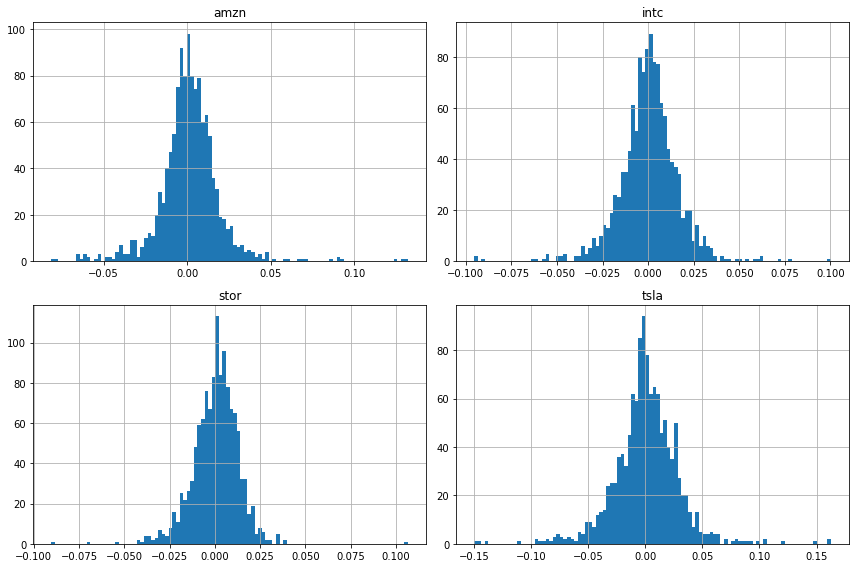

In [65]:
# Histogram of log returns
log_ret.hist(bins=100,figsize=(12,8))
plt.tight_layout()

In [66]:
# Mean log return of stock holdings
log_ret.mean()

tsla    0.000514
stor    0.000440
intc    0.000396
amzn    0.001424
dtype: float64

In [67]:
# Covariance of log returns (252 business days annually)
log_ret.cov() * 252

,tsla,stor,intc,amzn
tsla,0.201086,0.012124,0.032806,0.041120
stor,0.012124,0.040946,0.007211,0.009033
intc,0.032806,0.007211,0.065803,0.028211
amzn,0.041120,0.009033,0.028211,0.083988


In [79]:

np.random.seed(101) # sets seed value for random numbers to ensure random weights are the same every iteration

num_ports = 5000 # 5000 different portfolio allocations
all_weights = np.zeros((num_ports,len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    # Weights
    weights = np.array(np.random.random(4)) # allocating random weights
    weights = weights/np.sum(weights) # rebalacing so they equal 1
    
    #Save Weights
    all_weights[ind,:] = weights

    #Expected Return
    ret_arr[ind] = np.sum((log_ret.mean() * weights) * 252)

    #Expected Volatility
    vol_arr[ind] = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))

    #Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [81]:
# Maximum Sharpe ratio
sharpe_arr.max()

1.2759698518991784

In [82]:
# Index location of maximum Sharpe ratio
sharpe_arr.argmax()

4651

In [83]:
# Allocatons of stocks with maximum Sharpe ratio
all_weights[4651,:]

array([0.00962326, 0.32657241, 0.05042801, 0.61337633])

In [86]:
# Return and volatility at the maximum Sharpe ratio
max_sr_ret = ret_arr[4651]
max_sr_vol = vol_arr[4651]

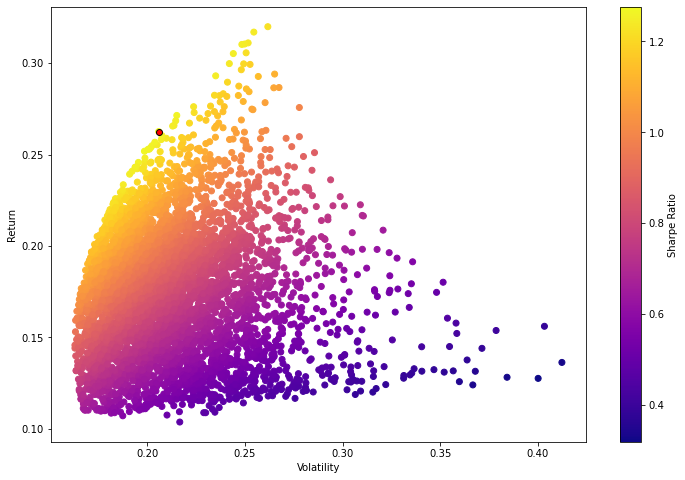

In [87]:
# Return against volatility scatter plot, coloured by the Sharpe ratio
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.scatter(max_sr_vol,max_sr_ret,c='red',edgecolor='black') # Plotting point of maximum Sharpe ratio

In [97]:
# Returning array of returns, volatility and Sharpe ratio for given weights
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [98]:
from scipy.optimize import minimize

In [99]:
# Returning negative Sharpe ratio to be minimised for given weights
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

In [100]:
def check_sum(weights):
    #return 0 if the sum of the weights is 1
    return np.sum(weights) - 1

In [102]:
# Minimise function constraints
cons = ({'type':'eq','fun':check_sum})

In [103]:
# Bounds of weight allocations between 0 and 1
bounds = ((0,1),(0,1),(0,1),(0,1))

In [107]:
# Initial weight guess for minimise function
init_guess = [0.25,0.25,0.25,0.25]

In [108]:
# Minimising function using SLSQP method
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [109]:
opt_results

     fun: -1.289806258370019
     jac: array([ 2.74351418e-01,  6.59674406e-05,  1.28509641e-01, -2.91913748e-05])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.        , 0.30694187, 0.        , 0.69305813])

In [110]:
# Final allocations
opt_results.x

array([0.        , 0.30694187, 0.        , 0.69305813])

In [111]:
# Showing returns, volatility and Sharpe ratio from function
get_ret_vol_sr(opt_results.x)

array([0.28270869, 0.21918694, 1.28980626])

In [119]:
# Creating frontier values for efficient frontier curve
frontier_y = np.linspace(0,0.4,100)

In [120]:
# Function to minimise volatility
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [121]:
# Calculating best possible return for each volatility
frontier_volatility=[]

for possible_return in frontier_y:
    cons = ({'type':'eq','fun':check_sum},
            {'type':'eq','fun':lambda w: get_ret_vol_sr(w)[0]-possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

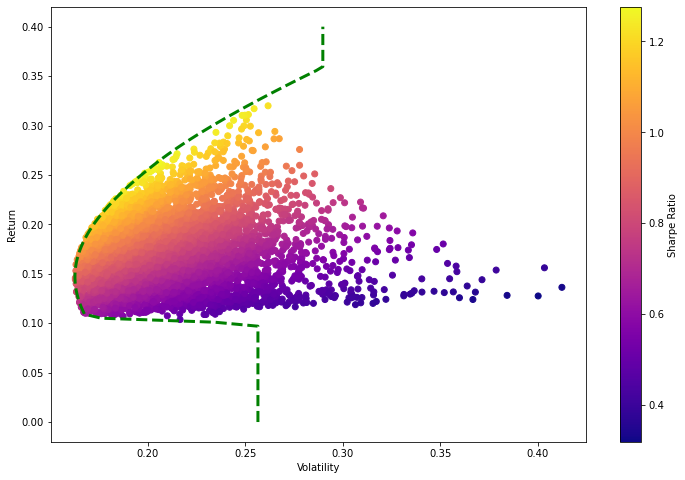

In [122]:
# Plotting frontier curve
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)